# Backtesting with refitting and rolling training window

[Forecasting for machine learning](https://www.trainindata.com/p/forecasting-with-machine-learning)

In this notebook we will show how to do **backtesting with refitting** on both **single and multiple time series** using a **direct forecasting** strategy. We will also have **exogenous features** and a **rolling training window**. We shall show an example with **multiple dependent time series (multivariate)** forecasting. We will use the `skforecast` package to help us do this.

To obtain a robust estimate of the model's predictive capacity, a backtesting process is carried out. The process of backtesting consists of evaluating the performance of a predictive model by applying it retrospectively to historical data. Therefore, it is a special type of cross-validation applied to the previous period(s).

Note: Since recording the videos, skforecast have made breaking changes to their API in newer versions (>= 0.14). This notebook has been updated for use with skforecast version 0.14 and above, which are the versions with a new API. If you are using older versions of skforecast (<0.14) see the migration guide here: https://skforecast.org/0.14.0/user_guides/migration-guide.html

**Backtesting with refit and fixed training size**

A technique similar to the previous one but, in this case, the training window rolls forward and the size of training remains constant. This is also known as time series cross-validation or walk-forward validation.

![image](./images/backtesting_refit_fixed_train_size.gif)

Image from [skforecast documentation](https://github.com/JoaquinAmatRodrigo/skforecast/blob/master/docs/img/backtesting_refit_fixed_train_size.gif)

This notebook is adapted from the [skforecast example notebook](https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html).



## Libraries

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Single time series

## Data


A time series is available with the monthly expenditure (millions of dollars) on corticosteroid drugs that the Australian health system had between 1991 and 2008. The data comes with two simulated exogenous variables. The data used in the examples of this document have been obtained from the magnificent book [Forecasting: Principles and Practice by Rob J Hyndman and George Athanasopoulos](https://otexts.com/fpp3/).

In [2]:
from skforecast.datasets import fetch_dataset

In [3]:
# Load the data
data = fetch_dataset(name="h2o_exog", raw=True)
data.head()

h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 4)


,fecha,y,exog_1,exog_2
0,1992-04-01,0.379808,0.958792,1.166029
1,1992-05-01,0.361801,0.951993,1.117859
2,1992-06-01,0.410534,0.952955,1.067942
3,1992-07-01,0.483389,0.958078,1.097376
4,1992-08-01,0.475463,0.956370,1.122199


The column `date` has been stored as a `string`. To convert it to `datetime` the `pd.to_datetime()` function can be use. Once in `datetime` format, and to make use of **Pandas** functionalities, it is set as an index. Also, since the data is monthly, the frequency is set as Monthly Started 'MS'.

In [4]:
# Data preparation
data = data.rename(columns={"fecha": "date"})
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")
data = data.set_index("date")
data = data.asfreq("MS")
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


When using the `asfreq()` method in Pandas, any gaps in the time series will be filled with `NaN` values to match the specified frequency. Therefore, it is essential to check for any missing values that may occur after this transformation.

In [5]:
# Check for missing values
print(f"Number of rows with missing values: {data.isnull().any(axis=1).sum()}")

Number of rows with missing values: 0


Text(0.5, 1.0, 'Monthly expenditure ($AUD) on corticosteroid drugs')

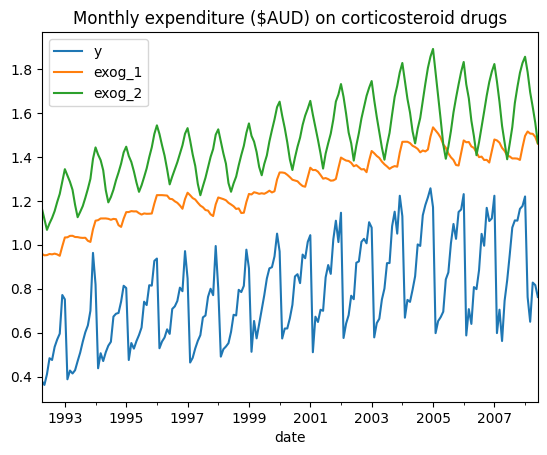

In [6]:
# Plot data
ax = data.plot()
ax.set_title("Monthly expenditure ($AUD) on corticosteroid drugs")

## Model (direct forecasting)

In [7]:
# Single time series forecasters (direct)
from skforecast.direct import ForecasterDirect

# Preprocessing and features
from sklearn.preprocessing import StandardScaler

# Traditional machine learning models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

With the `ForecasterDirect` class, a forecasting model is created and trained using a `Ridge` regressor with a time window of 6 lags. This means that the model uses the previous 6 months as predictors.

In [8]:
# Create forecaster
steps = 7  # Number of steps to forecast

forecaster = ForecasterDirect(
    regressor=Ridge(alpha=1, random_state=123),
    lags=6,
    steps=steps,
    transformer_y=StandardScaler(),  # Scaling helpful for
    transformer_exog=StandardScaler(),  # linear models.
)

## Backtesting

![image](./images/backtesting_refit_fixed_train_size.gif)

Image from [skforecast documentation](https://github.com/JoaquinAmatRodrigo/skforecast/blob/master/docs/img/backtesting_refit_fixed_train_size.gif)


In [9]:
from skforecast.model_selection import backtesting_forecaster, TimeSeriesFold

Note: The arguments needed to achieve this configuration are `refit=True` and `fixed_train_size=True`.

In [10]:
# Backtesting

# Forecast horizon & number of steps to move forecast origin
steps = 7

# Number of datapoints to test over
n_backtesting = steps * 3

# Initial training set size
initial_train_size = len(data) - n_backtesting

# Define how time series will be split during backtesting
cv = TimeSeriesFold(
    steps                 = steps,
    initial_train_size    = initial_train_size,
    skip_folds            = None,
    refit                 = True,
    fixed_train_size      = True,
    allow_incomplete_fold = True,
)

# Run backtesting
metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=data["y"],
    exog=data[["exog_1", "exog_2"]],
    cv=cv,
    metric="mean_squared_error",
    verbose=True,
    show_progress=True,
)

print(f"Backtest metric (MSE): {metric}")

Information of folds
--------------------
Number of observations used for initial training: 174
Number of observations used for backtesting: 21
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 2006-09-01 00:00:00  (n=174)
    Validation: 2006-10-01 00:00:00 -- 2007-04-01 00:00:00  (n=7)
Fold: 1
    Training:   1992-11-01 00:00:00 -- 2007-04-01 00:00:00  (n=174)
    Validation: 2007-05-01 00:00:00 -- 2007-11-01 00:00:00  (n=7)
Fold: 2
    Training:   1993-06-01 00:00:00 -- 2007-11-01 00:00:00  (n=174)
    Validation: 2007-12-01 00:00:00 -- 2008-06-01 00:00:00  (n=7)



  0%|          | 0/3 [00:00<?, ?it/s]

Backtest metric (MSE):    mean_squared_error
0            0.011914


In [11]:
metric

,mean_squared_error
0,0.011914


In [12]:
predictions.head()

,pred
2006-10-01,1.128978
2006-11-01,1.117235
2006-12-01,1.088585
2007-01-01,1.072753
2007-02-01,0.923374


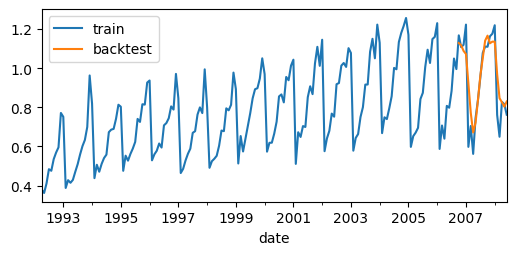

In [13]:
fig, ax = plt.subplots(figsize=(6, 2.5))
data["y"].plot(ax=ax, label="train")
predictions["pred"].plot(ax=ax, label="backtest")
ax.legend();

In [14]:
from sklearn.metrics import mean_squared_error

error_mse = mean_squared_error(
    y_true=data["y"].loc[predictions.index], y_pred=predictions
)

print(f"Test error (MSE) {error_mse}")

Test error (MSE) 0.011914023663703735


## Custom error metric

In the backtesting (`backtesting_forecaster`) and hyperparameter optimization (`grid_search_forecaster`) processes, besides the frequently used metrics such as `mean_squared_error` or `mean_absolute_error`, it is possible to use any custom function as long as:

+ It includes the arguments:

    + `y_true`: true values of the series.

    + `y_pred`: predicted values.

+ It returns a numeric value (`float` or `int`).

+ The metric is reduced as the model improves. Only applies in the `grid_search_forecaster` function if `return_best=True` (train the forecaster with the best model).

It allows evaluating the predictive capability of the model in a wide range of scenarios, for example:

+ Consider only certain months, days, hours...

+ Consider only dates that are holidays.

+ Consider only the last step of the predicted horizon.

The following example shows how to calculate the mean average percentage error (MAPE) which is: 

$$
100*\frac{1}{N}\sum_i{|\frac{y_i - \hat{y}_i}{y_i }}|
$$

In [15]:
# Custom metric
def custom_metric(y_true, y_pred):
    """
    Calculate the MAPE
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [16]:
# Backtesting
# Number of datapoints to test over
n_backtesting = steps * 3

# Initial training set size
initial_train_size = len(data) - n_backtesting

# Define how time series will be split during backtesting
cv = TimeSeriesFold(
    steps                 = steps,
    initial_train_size    = initial_train_size,
    skip_folds            = None,
    refit                 = True,
    fixed_train_size      = True,
    allow_incomplete_fold = True,
)


# Run backtesting
metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=data["y"],
    exog=data[["exog_1", "exog_2"]],
    cv=cv,
    metric=custom_metric,
    verbose=True,
    show_progress=True,
)

print(f"Backtest metric (MAPE): {metric}")

Information of folds
--------------------
Number of observations used for initial training: 174
Number of observations used for backtesting: 21
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 2006-09-01 00:00:00  (n=174)
    Validation: 2006-10-01 00:00:00 -- 2007-04-01 00:00:00  (n=7)
Fold: 1
    Training:   1992-11-01 00:00:00 -- 2007-04-01 00:00:00  (n=174)
    Validation: 2007-05-01 00:00:00 -- 2007-11-01 00:00:00  (n=7)
Fold: 2
    Training:   1993-06-01 00:00:00 -- 2007-11-01 00:00:00  (n=174)
    Validation: 2007-12-01 00:00:00 -- 2008-06-01 00:00:00  (n=7)



  0%|          | 0/3 [00:00<?, ?it/s]

Backtest metric (MAPE):    custom_metric
0       9.473809


# Multiple dependent time series (multivariate)

This dataset contains hourly air pollutant measurements in the City of Valencia.

source: Red de Vigilancia y Control de la Contaminación Atmosférica, 46250054-València - Centre, https://mediambient.gva.es/es/web/calidad-ambiental/datos-historicos

## Data

In [17]:
from skforecast.datasets import fetch_dataset

In [18]:
# Load the data
data = fetch_dataset(name="air_quality_valencia", raw=True)
data.head()

air_quality_valencia
--------------------
Hourly measures of several air chemical pollutant at Valencia city (Avd.
Francia) from 2019-01-01 to 20213-12-31. Including the following variables:
pm2.5 (µg/m³), CO (mg/m³), NO (µg/m³), NO2 (µg/m³), PM10 (µg/m³), NOx (µg/m³),
O3 (µg/m³), Veloc. (m/s), Direc. (degrees), SO2 (µg/m³).
Red de Vigilancia y Control de la Contaminación Atmosférica, 46250047-València -
Av. França, https://mediambient.gva.es/es/web/calidad-ambiental/datos-
historicos.
Shape of the dataset: (43824, 11)


,datetime,so2,co,no,no2,pm10,nox,o3,veloc.,direc.,pm2.5
0,2019-01-01 00:00:00,8.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,19.0
1,2019-01-01 01:00:00,8.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,26.0
2,2019-01-01 02:00:00,8.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,31.0
3,2019-01-01 03:00:00,10.0,0.1,15.0,41.0,35.0,63.0,3.0,0.2,220.0,30.0
4,2019-01-01 04:00:00,11.0,0.1,16.0,39.0,36.0,63.0,3.0,0.4,221.0,30.0


In [19]:
# Data preprocessing
data["datetime"] = pd.to_datetime(data["datetime"])
data = data.set_index("datetime")
data = data.asfreq("H")
data = data.sort_index()
data = data[["co", "so2", "pm2.5"]]
data.head()

/var/folders/xw/0ks6s8x53lvf4p3xdqzfh9300000gn/T/ipykernel_19888/3454319180.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.asfreq("H")


,co,so2,pm2.5
datetime,,,
2019-01-01 00:00:00,0.2,8.0,19.0
2019-01-01 01:00:00,0.1,8.0,26.0
2019-01-01 02:00:00,0.1,8.0,31.0
2019-01-01 03:00:00,0.1,10.0,30.0
2019-01-01 04:00:00,0.1,11.0,30.0


In [20]:
data.isnull().any()

co       True
so2      True
pm2.5    True
dtype: bool

In [21]:
# Impute missing values with forward filling
data = data.ffill()

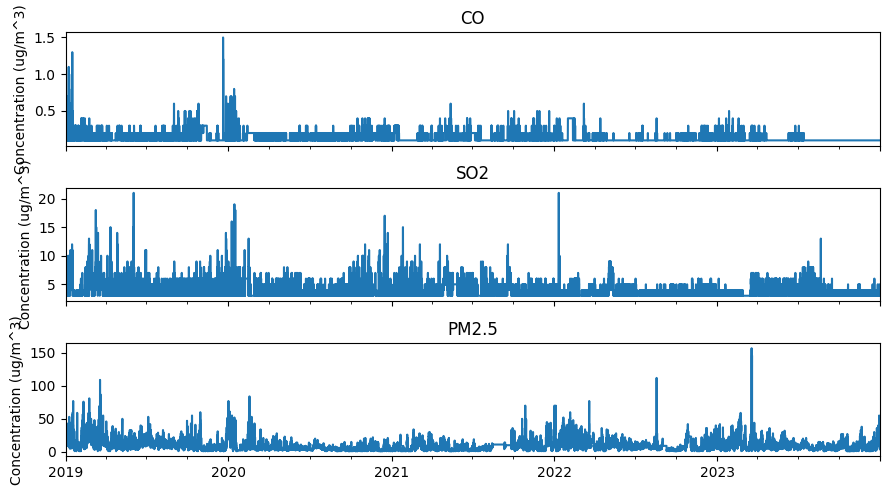

In [22]:
# Plot time series
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 5), sharex=True)

data["co"].plot(ax=axes[0])
axes[0].set_xlabel("")
axes[0].set_ylabel("Concentration (ug/m^3)")
axes[0].set_title("CO")

data["so2"].plot(ax=axes[1])
axes[1].set_xlabel("")
axes[1].set_ylabel("Concentration (ug/m^3)")
axes[1].set_title("SO2")

data["pm2.5"].plot(ax=axes[2])
axes[2].set_xlabel("")
axes[2].set_ylabel("Concentration (ug/m^3)")
axes[2].set_title("PM2.5")

fig.tight_layout()
plt.show();

Let's add the day of the week to use as an exogenous feature.

In [23]:
data["day_of_week"] = data.index.weekday

## Model (Dependent time series and direct forecasting)

In [24]:
# Preprocessing and features
from sklearn.preprocessing import StandardScaler

# Traditional machine learning models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Multiple dependent series forecasting (Direct)
from skforecast.direct import ForecasterDirectMultiVariate

In [25]:
# Define the forecaster
forecaster = ForecasterDirectMultiVariate(
    regressor=Ridge(alpha=1),
    level="co",
    lags=31,
    steps=24,
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
)

## Backtesting

![image](./images/backtesting_refit_fixed_train_size.gif)

Image from [skforecast documentation](https://github.com/JoaquinAmatRodrigo/skforecast/blob/master/docs/img/backtesting_refit_fixed_train_size.gif)


In [26]:
from skforecast.model_selection import backtesting_forecaster_multiseries

Note: The arguments needed to achieve this configuration are `refit=True` and `fixed_train_size=True`.


In [27]:
# Define column names of target variables that
# define the multivariate series
target_cols = ["co", "so2", "pm2.5"]

# Define column names of exogenous features
exog_features = ["day_of_week"]

# Forecast horizon & number of steps to move forecast origin
steps = 24

# Number of datapoints to test over
n_backtesting = steps * 3

# Initial training set size
initial_train_size = len(data) - n_backtesting

# Define how time series will be split during backtesting
cv = TimeSeriesFold(
    steps                 = steps,
    initial_train_size    = initial_train_size,
    skip_folds            = None,
    refit                 = True,
    fixed_train_size      = True,
    allow_incomplete_fold = True,
)

# Run backtesting
metric, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=data[target_cols],
    exog=data[exog_features],
    cv=cv,
    metric="mean_absolute_error",
    verbose=True,
    show_progress=True,
)

Information of folds
--------------------
Number of observations used for initial training: 43752
Number of observations used for backtesting: 72
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 24
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2019-01-01 00:00:00 -- 2023-12-28 23:00:00  (n=43752)
    Validation: 2023-12-29 00:00:00 -- 2023-12-29 23:00:00  (n=24)
Fold: 1
    Training:   2019-01-02 00:00:00 -- 2023-12-29 23:00:00  (n=43752)
    Validation: 2023-12-30 00:00:00 -- 2023-12-30 23:00:00  (n=24)
Fold: 2
    Training:   2019-01-03 00:00:00 -- 2023-12-30 23:00:00  (n=43752)
    Validation: 2023-12-31 00:00:00 -- 2023-12-31 23:00:00  (n=24)



/Users/kishanmanani/.pyenv/versions/3.12.3/envs/general/lib/python3.12/site-packages/skforecast/model_selection/_validation.py:644: LongTrainingWarning: The forecaster will be fit 72 times (3 folds * 24 regressors). This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

In [28]:
metric

,levels,mean_absolute_error
0,co,0.005522


In [29]:
predictions

,co
2023-12-29 00:00:00,0.097111
2023-12-29 01:00:00,0.094397
2023-12-29 02:00:00,0.093861
2023-12-29 03:00:00,0.093377
2023-12-29 04:00:00,0.094793
...,...
2023-12-31 19:00:00,0.110677
2023-12-31 20:00:00,0.112686
2023-12-31 21:00:00,0.116972
2023-12-31 22:00:00,0.115869


<Axes: >

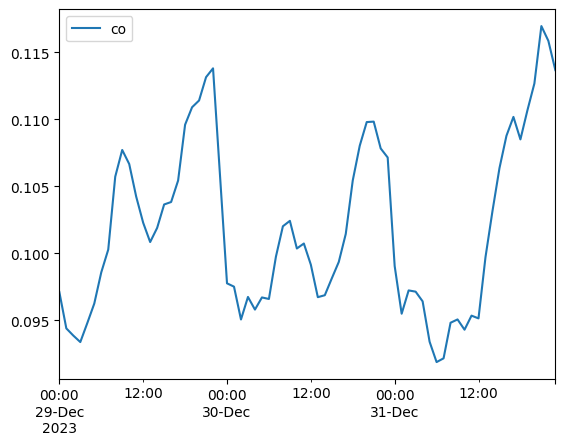

In [30]:
# Plot predictions
predictions.plot()